In [9]:
import pandas as pd
from nltk.tokenize import word_tokenize

#nltk.download('punkt')

# Declare the selected keyword
selected_keyword = ["well-being", "happiness", "life satisfaction", "liveability"]  # Initial value
translations = ["hyvinvointi", "vointi", "onnellisuus", "onni", "elämään tyytyväisyyttä", "elävyyttä"]
translations = translations + selected_keyword

# Load the CSV file into a DataFrame
df = pd.read_csv('data/parsed_data_sample.csv')
# Filter out only threads
threads_df = df[df['msg_type'] == 'thread_start']
print (threads_df)

# Function to check if the keyword is in the text
def contains_keyword(text):
    tokens = word_tokenize(text.lower())  # Convert text to lowercase for case-insensitive matching
    return any(translation in tokens for translation in translations)

# Filter threads containing the keyword in title or thread_text
filtered_threads = threads_df[threads_df['title'].apply(contains_keyword) | threads_df['thread_text'].apply(contains_keyword)]

# Save the filtered results to a new CSV file
filtered_threads[['title', 'thread_text', 'datetime']].to_csv('data/filtered_threads.csv', index=False)


            msg_type             datetime  \
0       thread_start  2018-01-01 00:00:00   
162     thread_start  2018-01-01 00:00:05   
466     thread_start  2018-01-01 00:01:40   
473     thread_start  2018-01-01 00:01:59   
738     thread_start  2018-01-01 00:07:08   
...              ...                  ...   
344338  thread_start  2018-01-24 14:06:46   
344343  thread_start  2018-01-24 14:07:07   
344344  thread_start  2018-01-24 14:08:01   
344345  thread_start  2018-01-24 14:08:34   
344347  thread_start  2018-01-24 14:08:51   

                                                    title  thread_id  \
0                                 Unohda en sinua koskaan   15127813   
162                     Hyvää Uutta Vuotta 2018 Kaikille!   15127814   
466                               Onnellista vuotta 2018!   15127815   
473                                    En Äänestä Larikaa   15127816   
738                                    Onko tosiaan niin,   15127818   
...                        

In [10]:
#Section 2
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Load the dataset
df = pd.read_csv('data/filtered_threads.csv')  # Replace with the path to your dataset

# Function to extract the year from the 'datetime' column
def extract_year(date_string):
    return int(date_string[:4])

# Create a dictionary to store sub-datasets for each year
yearly_datasets = {}

# Loop through the dataset and separate data for each year
for year in range(2001, 2019):
    # Filter data for the current year
    data_for_year = df[df['datetime'].apply(lambda x: extract_year(x) == year)]
    yearly_datasets[f'dat{year}'] = data_for_year

# Function to calculate vocabulary for each year
def get_vocabulary(data):
    tokens = []
    for text in data['thread_text']:
        if isinstance(text, str):  # Check if text is a valid string
            text = text.lower()  # Convert to lowercase for consistency
            tokens.extend(word_tokenize(text))
    fdist = FreqDist(tokens)
    return fdist  # Use FreqDist to get word frequencies

# Create a dictionary to store the vocabulary for each year
vocabulary_by_year = {}

# Calculate vocabulary for each year
for year, data in yearly_datasets.items():
    year_vocabulary = get_vocabulary(data)
    vocabulary_by_year[year] = year_vocabulary

# Print or manipulate the vocabulary data as needed
for year, vocab in vocabulary_by_year.items():
    print(f"Year {year}: Vocabulary Size = {len(vocab)}")

Year dat2001: Vocabulary Size = 0
Year dat2002: Vocabulary Size = 0
Year dat2003: Vocabulary Size = 0
Year dat2004: Vocabulary Size = 0
Year dat2005: Vocabulary Size = 0
Year dat2006: Vocabulary Size = 0
Year dat2007: Vocabulary Size = 0
Year dat2008: Vocabulary Size = 0
Year dat2009: Vocabulary Size = 0
Year dat2010: Vocabulary Size = 0
Year dat2011: Vocabulary Size = 0
Year dat2012: Vocabulary Size = 0
Year dat2013: Vocabulary Size = 0
Year dat2014: Vocabulary Size = 0
Year dat2015: Vocabulary Size = 0
Year dat2016: Vocabulary Size = 0
Year dat2017: Vocabulary Size = 0
Year dat2018: Vocabulary Size = 1899


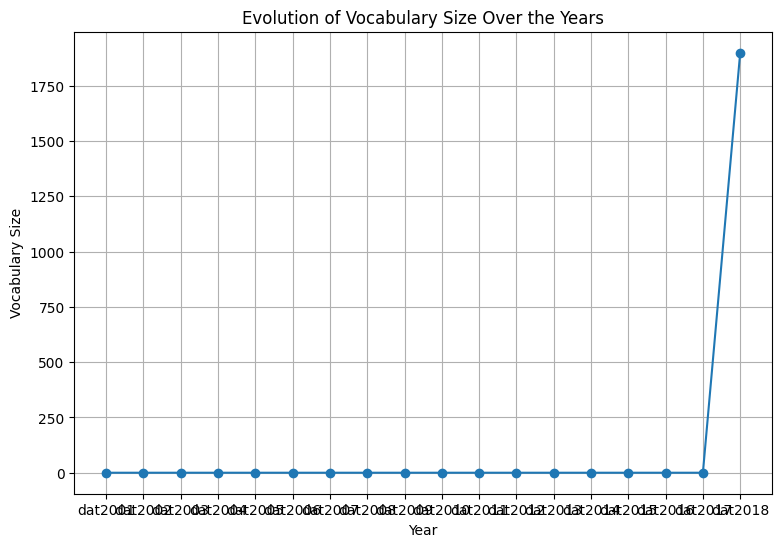

In [15]:
#Section3
import matplotlib.pyplot as plt

# Extract require data
years = list(vocabulary_by_year.keys())
vocab_sizes = [len(vocab) for vocab in vocabulary_by_year.values()]

# Create a line plot to show vocabulary evolution over the years
plt.figure(figsize=(9, 6))
plt.plot(years, vocab_sizes, marker='o', linestyle='-')
plt.title('Evolution of Vocabulary Size Over the Years')
plt.xlabel('Year')
plt.ylabel('Vocabulary Size')
plt.grid(True)
plt.show()


In [19]:
#Section 4
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

results = {}
confidence_levels = [0.8, 0.85, 0.9, 0.95]
# Loop for each year
for year, data in yearly_datasets.items():
    tokens = []
    vocab_sizes = []
    for text in data['thread_text']:
        if isinstance(text, str):
            text = text.lower()
            tokenized = word_tokenize(text)
            tokens.extend(tokenized)
            vocab_sizes.append(len(set(tokens)))

    #  a linear regression model (Heaps law) 
    x = np.arange(1, len(tokens) + 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(vocab_sizes))

    # Calculate predicted vocabulary size by  linear model
    predicted_vocab_sizes = np.exp(slope * np.log(x) + intercept)

    # Calculate the upper and lower bounds based on the confidence level
    bounds = []
    for confidence in confidence_levels:
        n = len(tokens)
        t = stats.t.ppf(1 - (1 - confidence) / 2, n - 2)
        prediction_interval = t * std_err * np.sqrt(1 + 1 / n + (np.log(x) - np.mean(np.log(x))) ** 2 / ((n - 1) * np.var(np.log(x))))
        upper_bound = predicted_vocab_sizes * np.exp(prediction_interval)
        lower_bound = predicted_vocab_sizes / np.exp(prediction_interval)
        bounds.append((upper_bound, lower_bound))

    results[year] = {
        'tokens': tokens,
        'vocab_sizes': vocab_sizes,
        'predicted_vocab_sizes': predicted_vocab_sizes,
        'confidence_bounds': bounds
    }

# Plot graphs 
for year, data in results.items():
    plt.figure(figsize=(10, 6))
    x = np.arange(1, len(data['tokens']) + 1)
    plt.plot(x, data['vocab_sizes'], label='Actual Vocabulary Size')
    plt.plot(x, data['predicted_vocab_sizes'], label='Predicted Vocabulary Size', linestyle='--')
    for i, confidence in enumerate(confidence_levels):
        plt.fill_between(x, data['confidence_bounds'][i][0], data['confidence_bounds'][i][1], alpha=0.2, label=f'{confidence*100}% Confidence Bound')
    plt.title(f'Vocabulary Size vs. Tokens - Year {year}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Vocabulary Size')
    plt.legend()
    plt.grid(True)

    # Count points outside the bounds for each confidence level
    for i, confidence in enumerate(confidence_levels):
        upper_bound = data['confidence_bounds'][i][0]
        lower_bound = data['confidence_bounds'][i][1]
        outside_bounds = sum((data['vocab_sizes'] > upper_bound) | (data['vocab_sizes'] < lower_bound))
        print(f"Year {year}, {confidence*100}% Confidence: {outside_bounds} points outside bounds")

    plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 163 and the array at index 1 has size 1